### **ASSIGNMENT-3**

Use the Plant Seedlings Dataset to attempt the following questions.
1. Write your own functions to load the data, normalize the data, OHE for categories.
2. If you find unbalanced data, augment the classes accordingly.
3. Use pre-trained **VGG16, ResNet50 and InceptionV3** networks to extract bottleneck features
and build a model on top of each of them to evaluate and compare the model performances.
(Model performances include classification report, confusion matrices, plots of Loss Vs Epochs)
4. Write 2 separate scripts
<ol>a. To train the network and save the model with highest validation accuracy. Save model - model.save("model.h5")</ol>
<ol>b Load the model and predict on the test data.
Load Model - model = load_model("model.h5")</ol>

Steps to follow:
<ol>1. Loading dataset and Preprocessing of data</ol>


In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

1. Loading Dataset and Preprocessing of data

In [1]:
import os
import keras
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from IPython.display import Image
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import VGG16,ResNet50,InceptionV3
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path='C:/Users/nivik/Downloads/plant-seedlings-classification'
train_file_path=os.path.join(base_path,'train/')
test_file_path=os.path.join(base_path,'test/')

In [3]:
#checking if the data in each folder is equal
def extraction(train_file_path):
    
    count=[]
    classes=os.listdir(train_file_path)
    for class_name in classes:
        class_path = os.path.join(train_file_path, class_name)
        count.append(len(os.listdir(class_path)))
        
    return classes,count

In [4]:
#extracting the class images and number of folders in it.
print(f"Number of images in each class:")
classes, count=extraction(train_file_path)
for i in range(len(classes)):
    print(f"{classes[i]}: {count[i]}")

Number of images in each class:
Black-grass: 263
Charlock: 390
Cleavers: 287
Common Chickweed: 611
Common wheat: 221
Fat Hen: 475
Loose Silky-bent: 654
Maize: 221
Scentless Mayweed: 516
Shepherds Purse: 231
Small-flowered Cranesbill: 496
Sugar beet: 385


In [5]:
#data without data augmentation
#training data
images=[]
labels=[]
classes=os.listdir(train_file_path)# list of all the names of seedlings folders
class_paths=[os.path.join(train_file_path,name) for name in classes]
for path in class_paths:
    for i in os.listdir(path):
        img = np.asarray(Image.open(os.path.join(path,i)).resize((224, 224)).convert('RGB'))/255.0
        images.append(img)
        labels.append(path[62:])

In [6]:
np.array(images).shape, np.array(labels).shape

((4750, 224, 224, 3), (4750,))

In [7]:
images_shuffled, labels_shuffled=shuffle(np.array(images),np.array(labels))
label_encoder = LabelEncoder()
labels_shuffled = label_encoder.fit_transform(labels_shuffled)
X_train, X_valid, y_train, y_valid = train_test_split(images_shuffled, labels_shuffled, test_size=0.2, random_state=0)
y_train_categorical=keras.utils.to_categorical(y_train,num_classes=12)
y_valid_categorical=keras.utils.to_categorical(y_valid,num_classes=12)
X_train.shape,X_valid.shape,y_train_categorical.shape,y_valid_categorical.shape

((3800, 224, 224, 3), (950, 224, 224, 3), (3800, 12), (950, 12))

Text(0.5, 0.98, 'Plant Seedling')

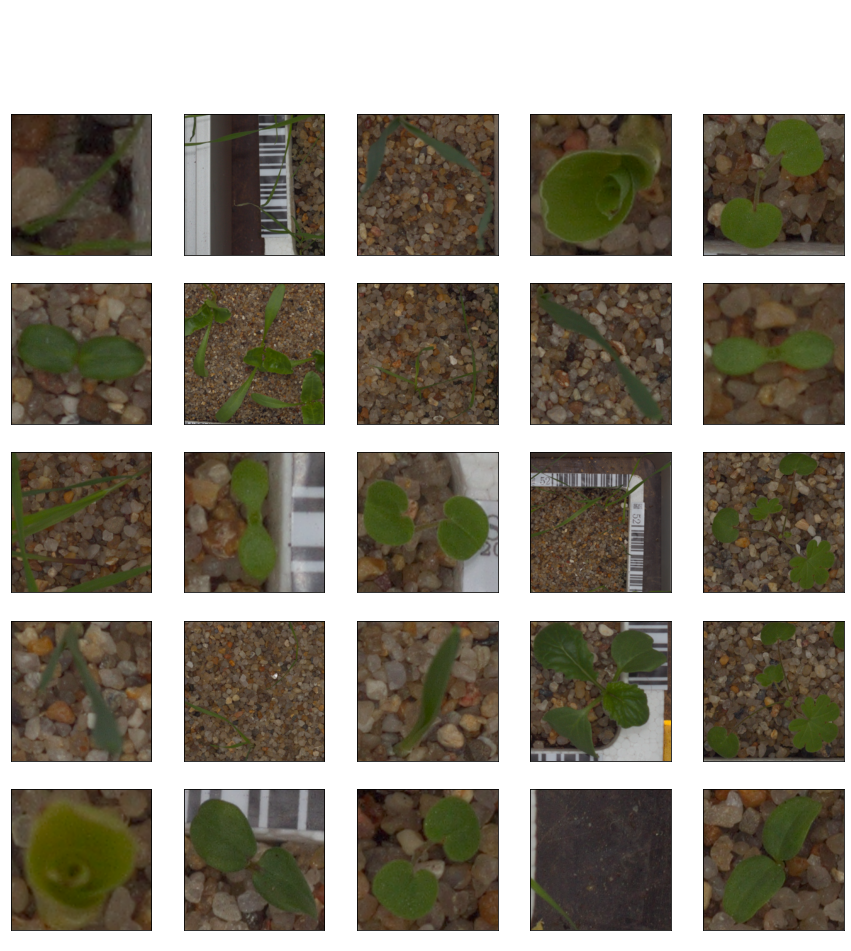

In [9]:
fig=plt.figure(figsize=(15,15))
for i in range(25):
    fig.add_subplot(5,5,i+1)
    plt.imshow(X_train[i],cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    predict=classes[np.argmax(y_train_categorical[i])]
    plt.xlabel(predict,color='white')
fig.suptitle("Plant Seedling",color='white')

2. Model building from pre-trained model

The pre-trained models like VGG16, Resnet50 and Inceptionv3 will be used here. The basics steps are:
    <ol>A. Get the base model like VGG16 ready and freeze all the layers of the model so the weights dont change</ol>
    <ol>B. Before extracting the bottleneck features, the images are to be converted into normalized float values from unsigned int</ol>
    <ol>C. To extract the bottleneck features, use the predict function</ol>

In [8]:
# Extract bottleneck features
def extract_bottleneck_features(data, base_model):
    bottleneck_features= base_model.predict(data)
    return bottleneck_features

# Build a model on top of pre-trained model
def build_model(base_model):
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=keras.layers.Flatten()(x)
    x=keras.layers.BatchNormalization()(x)
    x=Dense(1024,activation='relu')(x)
    x=keras.layers.Dropout(0.2)(x)
    prediction=Dense(len(classes), activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.output, outputs=prediction)
    for layer in model.layers[-12:]:
        layer.trainable=True
    return model

# Plot Loss vs. Epochs
def plot_loss(history,title):
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss vs. Epochs - ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
earlystopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=8,factor=0.2,min_lr=0.0001)

a. VGG16

In [9]:
# Load pre-trained VGG16 without top layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_vgg.layers:
    layer.trainable=False
    
# Extract bottleneck features for training and testing data
bottleneck_features_train_vgg = extract_bottleneck_features(X_train, base_model_vgg)
bottleneck_features_valid_vgg = extract_bottleneck_features(X_valid, base_model_vgg)

30/30 [==============================] - 147s 5s/step


In [10]:
# Compile and train the model
model_vgg = build_model(base_model_vgg)
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(bottleneck_features_train_vgg, y_train_categorical, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
107/107 [==============================] - 2s 11ms/step - loss: 1.5301 - accuracy: 0.4950 - val_loss: 2.1799 - val_accuracy: 0.2447 - lr: 0.0010
Epoch 2/20
107/107 [==============================] - 1s 10ms/step - loss: 0.9561 - accuracy: 0.6681 - val_loss: 1.6815 - val_accuracy: 0.5053 - lr: 0.0010
Epoch 3/20
107/107 [==============================] - 1s 10ms/step - loss: 0.7909 - accuracy: 0.7251 - val_loss: 1.2270 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 4/20
107/107 [==============================] - 1s 10ms/step - loss: 0.6857 - accuracy: 0.7681 - val_loss: 0.9690 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 5/20
107/107 [==============================] - 1s 9ms/step - loss: 0.6251 - accuracy: 0.7830 - val_loss: 0.9112 - val_accuracy: 0.6816 - lr: 0.0010
Epoch 6/20
107/107 [==============================] - 1s 10ms/step - loss: 0.5718 - accuracy: 0.8041 - val_loss: 0.8703 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 7/20
107/107 [==============================] - 1s 9ms/step

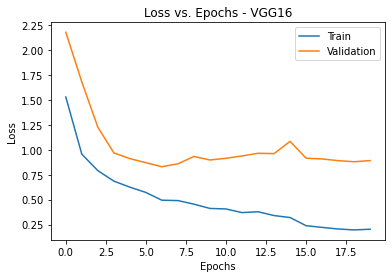

In [11]:
#plot loss vs epochs
plot_loss(history_vgg,"VGG16")

In [12]:
#Evaluation
vgg_evaluate=model_vgg.evaluate(bottleneck_features_valid_vgg,y_valid_categorical)
vgg_evaluate

30/30 [==============================] - 0s 3ms/step - loss: 0.8760 - accuracy: 0.7400


[0.8760408163070679, 0.7400000095367432]

30/30 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        52
           1       0.80      0.80      0.80        71
           2       0.75      0.70      0.72        43
           3       0.82      0.85      0.83       123
           4       0.77      0.56      0.65        43
           5       0.61      0.71      0.66        92
           6       0.73      0.83      0.78       143
           7       0.74      0.84      0.78        37
           8       0.61      0.77      0.68        91
           9       0.64      0.40      0.49        58
          10       0.85      0.89      0.87       105
          11       0.88      0.66      0.76        92

    accuracy                           0.74       950
   macro avg       0.74      0.71      0.71       950
weighted avg       0.74      0.74      0.74       950

Confusion Matrix:


Text(159.0, 0.5, 'Predict')

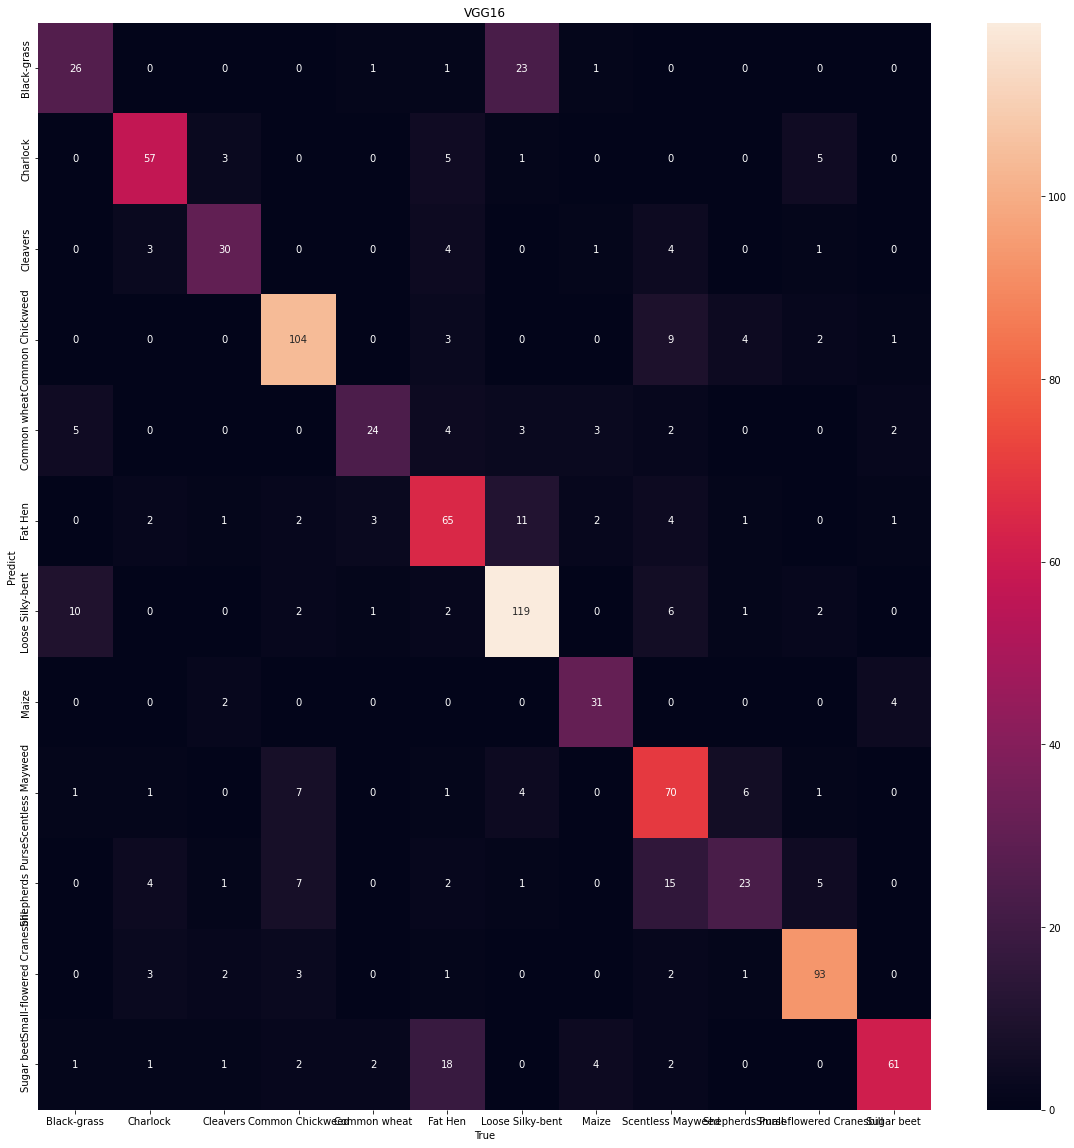

In [13]:
# Generate classification report and confusion matrix
y_pred = model_vgg.predict(bottleneck_features_valid_vgg)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes))
ax1.set_yticklabels(list(classes))
plt.title("VGG16")
plt.xlabel("True")
plt.ylabel("Predict")

In [43]:
#save model
model_vgg.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_vgg.keras')

b. ResNet50

In [14]:
# Load pre-trained ResNet50 without top layers
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_res.layers:
    layer.trainable=False
    
# Extract bottleneck features for training and testing data
bottleneck_features_train_res = extract_bottleneck_features(keras.applications.resnet.preprocess_input(X_train*255.0), base_model_res)
bottleneck_features_valid_res = extract_bottleneck_features(keras.applications.resnet.preprocess_input(X_valid*255.0), base_model_res)

30/30 [==============================] - 58s 2s/step


In [15]:
# Compile and train the model
model_res = build_model(base_model_res)
model_res.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_res = model_res.fit(bottleneck_features_train_res, y_train_categorical, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
107/107 [==============================] - 3s 23ms/step - loss: 1.1882 - accuracy: 0.6307 - val_loss: 0.8925 - val_accuracy: 0.8053 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 2s 22ms/step - loss: 0.4803 - accuracy: 0.8550 - val_loss: 0.5526 - val_accuracy: 0.8368 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 2s 21ms/step - loss: 0.2882 - accuracy: 0.9137 - val_loss: 0.4156 - val_accuracy: 0.8553 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 2s 22ms/step - loss: 0.1928 - accuracy: 0.9471 - val_loss: 0.3864 - val_accuracy: 0.8711 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 2s 21ms/step - loss: 0.1397 - accuracy: 0.9661 - val_loss: 0.3744 - val_accuracy: 0.8816 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 2s 21ms/step - loss: 0.1018 - accuracy: 0.9763 - val_loss: 0.3676 - val_accuracy: 0.8842 - lr: 1.0000e-04
Epoch 7/20
107/107 [====================

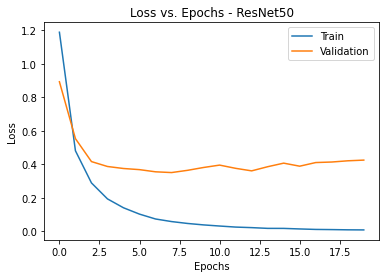

In [16]:
#plot loss vs epochs
plot_loss(history_res,"ResNet50")

In [17]:
#Evaluation
res_evaluate=model_res.evaluate(bottleneck_features_valid_res,y_valid_categorical)
res_evaluate

 1/30 [>.............................] - ETA: 1s - loss: 0.2547 - accuracy: 0.8438

30/30 [==============================] - 0s 6ms/step - loss: 0.3867 - accuracy: 0.8874


[0.38668563961982727, 0.8873684406280518]

30/30 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        52
           1       0.97      0.97      0.97        71
           2       0.98      0.95      0.96        43
           3       0.85      0.95      0.90       123
           4       0.90      0.86      0.88        43
           5       0.93      0.92      0.93        92
           6       0.81      0.91      0.86       143
           7       1.00      0.95      0.97        37
           8       0.86      0.87      0.86        91
           9       0.88      0.72      0.79        58
          10       0.95      0.98      0.97       105
          11       0.98      0.90      0.94        92

    accuracy                           0.89       950
   macro avg       0.89      0.87      0.88       950
weighted avg       0.89      0.89      0.88       950

Confusion Matrix:


Text(159.0, 0.5, 'Predict')

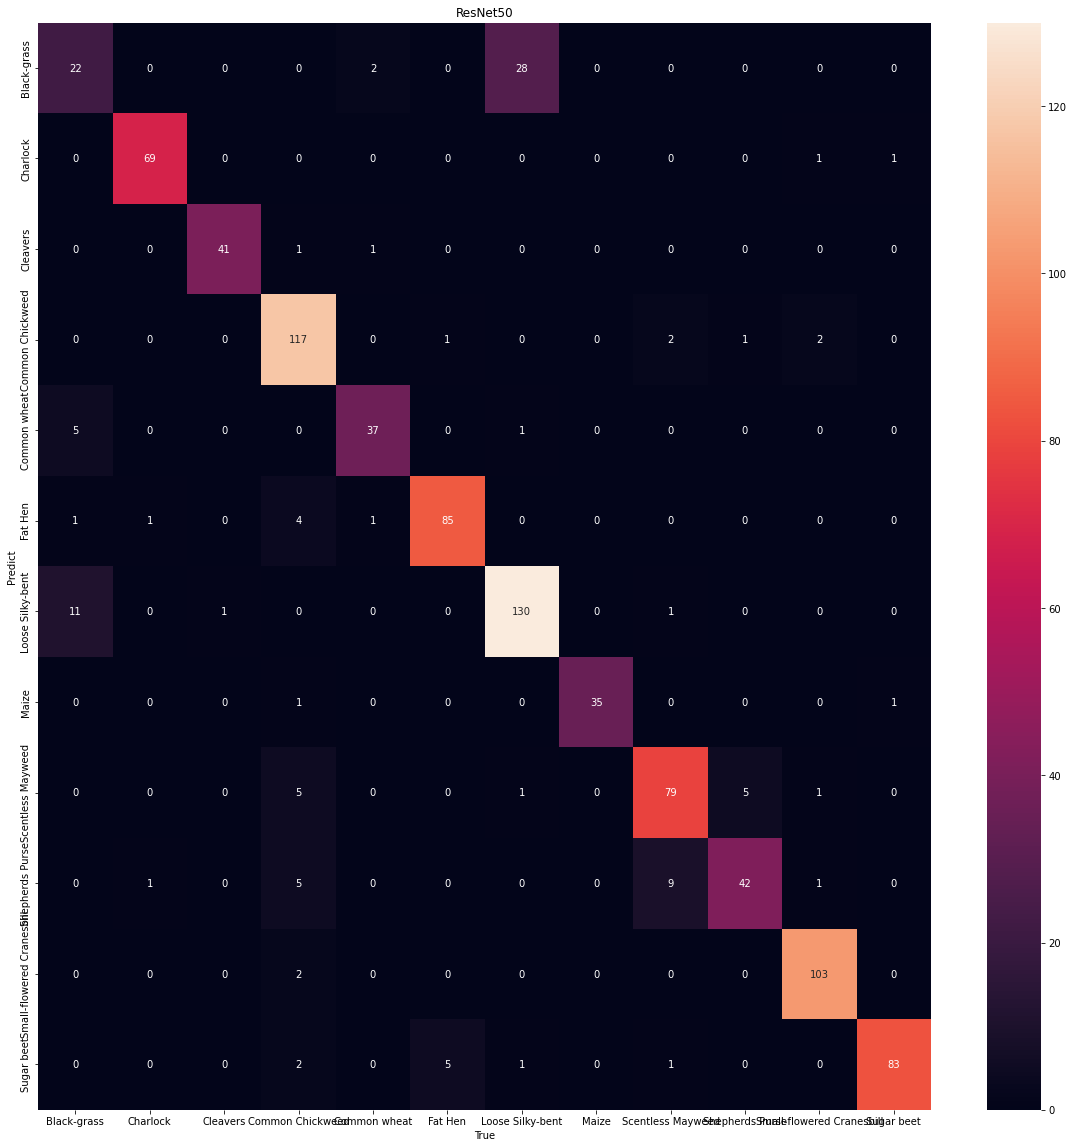

In [18]:
# Generate classification report and confusion matrix
y_pred = model_res.predict(bottleneck_features_valid_res)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes))
ax1.set_yticklabels(list(classes))
plt.title("ResNet50")
plt.xlabel("True")
plt.ylabel("Predict")


In [42]:
#save model
model_res.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_res.keras')

c. Inceptionv3

In [19]:
# Load pre-trained InceptionV3 without top layers
base_model_incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_incep.layers:
    layer.trainable=False
    
# Extract bottleneck features for training and testing data
bottleneck_features_train_incep = extract_bottleneck_features(X_train, base_model_incep)
bottleneck_features_valid_incep = extract_bottleneck_features(X_valid, base_model_incep)

30/30 [==============================] - 35s 1s/step


In [20]:
# Compile and train the model
model_incep = build_model(base_model_incep)
model_incep.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_incep = model_incep.fit(bottleneck_features_train_incep, y_train_categorical, epochs=20, validation_split=0.1,callbacks=[reduce_lr])

Epoch 1/20
107/107 [==============================] - 3s 22ms/step - loss: 1.2517 - accuracy: 0.5965 - val_loss: 0.9948 - val_accuracy: 0.7368 - lr: 1.0000e-04
Epoch 2/20
107/107 [==============================] - 2s 20ms/step - loss: 0.5699 - accuracy: 0.8146 - val_loss: 0.6537 - val_accuracy: 0.8053 - lr: 1.0000e-04
Epoch 3/20
107/107 [==============================] - 2s 21ms/step - loss: 0.3570 - accuracy: 0.8909 - val_loss: 0.5585 - val_accuracy: 0.8184 - lr: 1.0000e-04
Epoch 4/20
107/107 [==============================] - 2s 21ms/step - loss: 0.2437 - accuracy: 0.9310 - val_loss: 0.5443 - val_accuracy: 0.8316 - lr: 1.0000e-04
Epoch 5/20
107/107 [==============================] - 2s 22ms/step - loss: 0.1684 - accuracy: 0.9591 - val_loss: 0.5435 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 6/20
107/107 [==============================] - 2s 22ms/step - loss: 0.1188 - accuracy: 0.9716 - val_loss: 0.5294 - val_accuracy: 0.8105 - lr: 1.0000e-04
Epoch 7/20
107/107 [====================

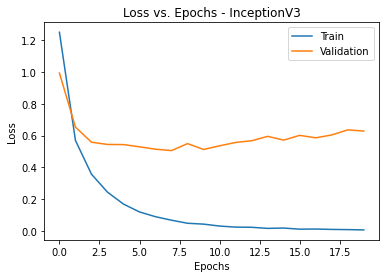

In [21]:
#plot loss vs epochs
plot_loss(history_incep,"InceptionV3")

In [22]:
#Evaluation
incep_evaluate=model_incep.evaluate(bottleneck_features_valid_incep,y_valid_categorical)
incep_evaluate

30/30 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.8411


[0.696051299571991, 0.8410526514053345]

30/30 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        52
           1       0.94      0.93      0.94        71
           2       0.94      0.77      0.85        43
           3       0.93      0.85      0.89       123
           4       0.82      0.86      0.84        43
           5       0.81      0.84      0.82        92
           6       0.75      0.90      0.82       143
           7       1.00      0.89      0.94        37
           8       0.75      0.88      0.81        91
           9       0.76      0.55      0.64        58
          10       0.89      0.98      0.93       105
          11       0.93      0.89      0.91        92

    accuracy                           0.84       950
   macro avg       0.85      0.82      0.83       950
weighted avg       0.84      0.84      0.84       950

Confusion Matrix:


Text(159.0, 0.5, 'Predict')

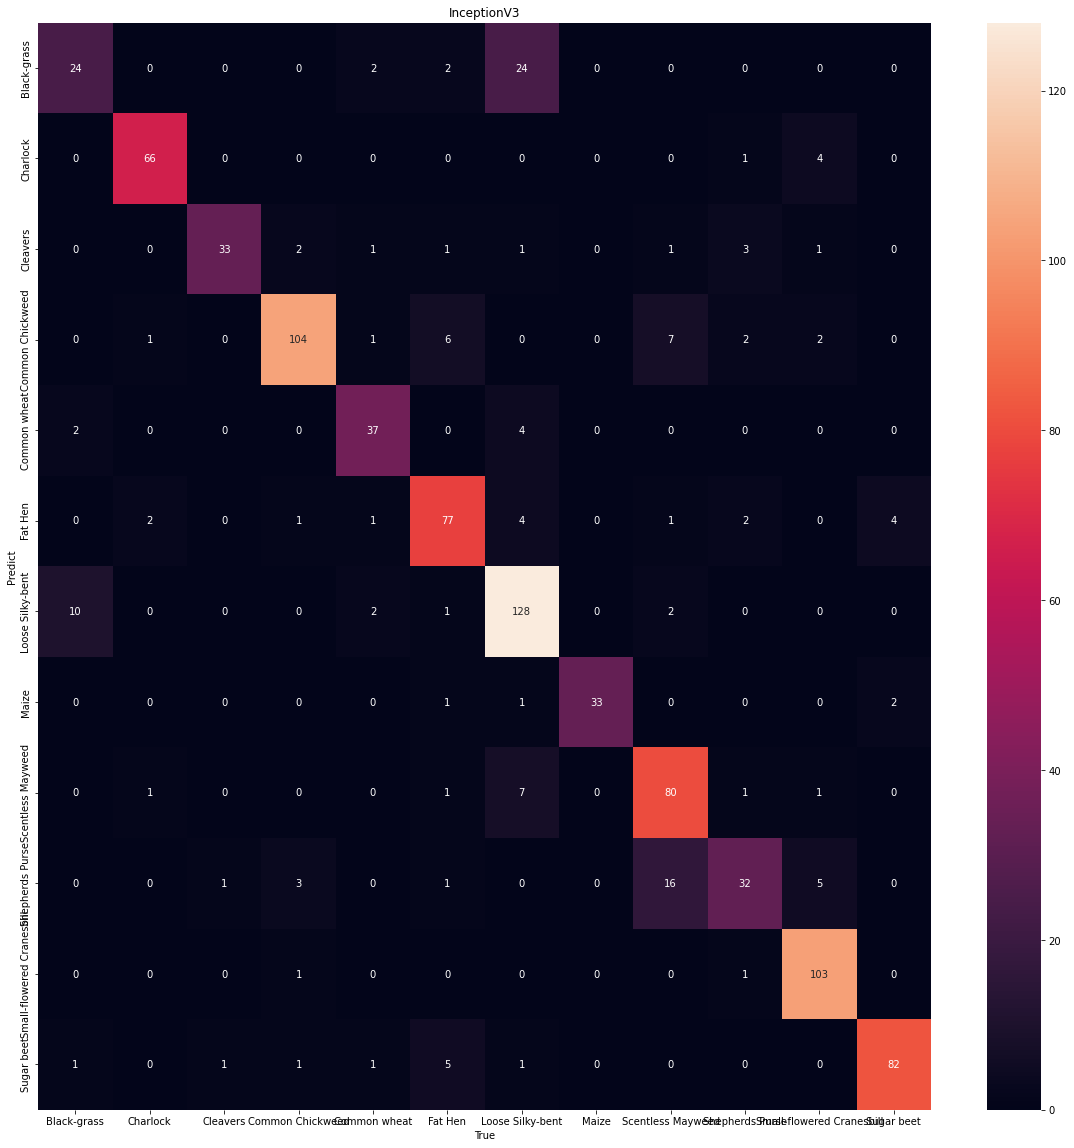

In [23]:
# Generate classification report and confusion matrix
y_pred = model_incep.predict(bottleneck_features_valid_incep)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid_categorical, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
cm2=confusion_matrix(y_true,y_pred_classes)
plt.figure(figsize=(20,20))
ax1=sn.heatmap(cm2,annot=True,fmt='g')
ax1.set_xticklabels(list(classes))
ax1.set_yticklabels(list(classes))
plt.title("InceptionV3")
plt.xlabel("True")
plt.ylabel("Predict")

In [41]:
#save model
model_incep.save('C:/Users/nivik/Downloads/plant-seedlings-classification/model_incep.keras')

Without data augmentation,
<ul> MODEL------------------ACCURACY</ul>
<ul> VGG16------------------73.00%</ul>
<ul> ResNet50---------------88.73%</ul>
<ul> InceptionV3------------84.10%</ul>